# 算法原理

与XGBoost、LightGBM相比，CatBoost的创新点有：

- 嵌入了自动将类别型特征处理为数值型特征的创新算法。首先对categorical features做一些统计，计算某个类别特征（category）出现的频率，之后加上超参数，生成新的数值型特征（numerical features）。
- Catboost还使用了组合类别特征，可以利用到特征之间的联系，这极大的丰富了特征维度。
- 采用排序提升的方法对抗训练集中的噪声点，从而避免梯度估计的偏差，进而解决预测偏移的问题。
- 采用了完全对称树作为基模型。

**类别型特征**

1、类别型特征的相关工作

所谓类别型特征，即这类特征不是数值型特征，而是离散的集合，比如省份名（山东、山西、河北等），城市名（北京、上海、深圳等），学历（本科、硕士、博士等）。在梯度提升算法中，最常用的是将这些类别型特征转为数值型来处理，一般类别型特征会转化为一个或多个数值型特征。

如果某个类别型特征基数比较低（low-cardinality features），即该特征的所有值去重后构成的集合元素个数比较少，一般利用One-hot编码方法将特征转为数值型。One-hot编码可以在数据预处理时完成，也可以在模型训练的时候完成，从训练时间的角度，后一种方法的实现更为高效，CatBoost对于基数较低的类别型特征也是采用后一种实现。

显然，在高基数类别型特征（high cardinality features）当中，比如 user ID，这种编码方式会产生大量新的特征，造成维度灾难。一种折中的办法是可以将类别分组成有限个的群体再进行One-hot编码。一种常被使用的方法是根据目标变量统计（Target Statistics，以下简称TS）进行分组，目标变量统计用于估算每个类别的目标变量期望值。甚至有人直接用TS作为一个新的数值型变量来代替原来的类别型变量。重要的是，可以通过对TS数值型特征的阈值设置，基于对数损失、基尼系数或者均方差，得到一个对于训练集而言将类别一分为二的所有可能划分当中最优的那个。在LightGBM当中，类别型特征用每一步梯度提升时的梯度统计（Gradient Statistics，以下简称GS）来表示。虽然为建树提供了重要的信息，但是这种方法有以下两个缺点：

增加计算时间，因为需要对每一个类别型特征，在迭代的每一步，都需要对GS进行计算；
增加存储需求，对于一个类别型变量，需要存储每一次分离每个节点的类别；
为了克服这些缺点，LightGBM以损失部分信息为代价将所有的长尾类别归为一类，作者声称这样处理高基数类别型特征时比One-hot编码还是好不少。不过如果采用TS特征，那么对于每个类别只需要计算和存储一个数字。

因此，采用TS作为一个新的数值型特征是最有效、信息损失最小的处理类别型特征的方法。TS也被广泛应用在点击预测任务当中，这个场景当中的类别型特征有用户、地区、广告、广告发布者等。接下来我们着重讨论TS，暂时将One-hot编码和GS放一边。

2、目标变量统计（Target Statistics）

CatBoost算法的设计初衷是为了更好的处理GBDT特征中的categorical features。在处理 GBDT特征中的categorical features的时候，最简单的方法是用 categorical feature 对应的标签的平均值来替换。在决策树中，标签平均值将作为节点分裂的标准。这种方法被称为 Greedy Target-based Statistics , 简称 Greedy TS，用公式来表达就是：

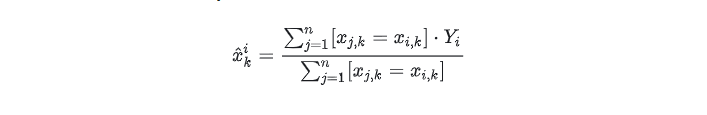

这种方法有一个显而易见的缺陷，就是通常特征比标签包含更多的信息，如果强行用标签的平均值来表示特征的话，当训练数据集和测试数据集数据结构和分布不一样的时候会出条件偏移问题。

一个标准的改进 Greedy TS的方式是添加先验分布项，这样可以减少噪声和低频率类别型数据对于数据分布的影响：

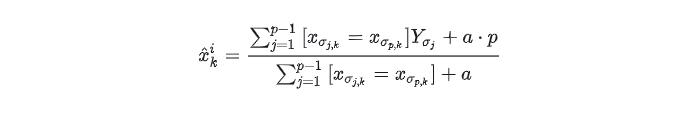

其中p是添加的先验项，a通常是大于0的权重系数。添加先验项是一个普遍做法，针对类别数较少的特征，它可以减少噪声数据。对于回归问题，一般情况下，先验项可取数据集label的均值。对于二分类，先验项是正例的先验概率。利用多个数据集排列也是有效的，但是，如果直接计算可能导致过拟合。CatBoost利用了一个比较新颖的计算叶子节点值的方法，这种方式(oblivious trees，对称树)可以避免多个数据集排列中直接计算会出现过拟合的问题。

3、特征组合

值得注意的是几个类别型特征的任意组合都可视为新的特征。例如，在音乐推荐应用中，我们有两个类别型特征：用户ID和音乐流派。如果有些用户更喜欢摇滚乐，将用户ID和音乐流派转换为数字特征时，根据上述这些信息就会丢失。结合这两个特征就可以解决这个问题，并且可以得到一个新的强大的特征。然而，组合的数量会随着数据集中类别型特征的数量成指数增长，因此不可能在算法中考虑所有组合。为当前树构造新的分割点时，CatBoost会采用贪婪的策略考虑组合。对于树的第一次分割，不考虑任何组合。对于下一个分割，CatBoost将当前树的所有组合、类别型特征与数据集中的所有类别型特征相结合，并将新的组合类别型特征动态地转换为数值型特征。CatBoost还通过以下方式生成数值型特征和类别型特征的组合：树中选定的所有分割点都被视为具有两个值的类别型特征，并像类别型特征一样被进行组合考虑。

4、CatBoost处理Categorical features总结

- 首先会计算一些数据的statistics。计算某个category出现的频率，加上超参数，生成新的numerical features。这一策略要求同一标签数据不能排列在一起（即先全是0之后全是1这种方式），训练之前需要打乱数据集。
- 第二，使用数据的不同排列（实际上是4个）。在每一轮建立树之前，先扔一轮骰子，决定使用哪个排列来生成树。
- 第三，考虑使用categorical features的不同组合。例如颜色和种类组合起来，可以构成类似于blue dog这样的特征。当需要组合的categorical features变多时，CatBoost只考虑一部分combinations。在选择第一个节点时，只考虑选择一个特征，例如A。在生成第二个节点时，考虑A和任意一个categorical feature的组合，选择其中最好的。就这样使用贪心算法生成combinations。
- 第四，除非向gender这种维数很小的情况，不建议自己生成One-hot编码向量，最好交给算法来处理。

**克服梯度偏差**

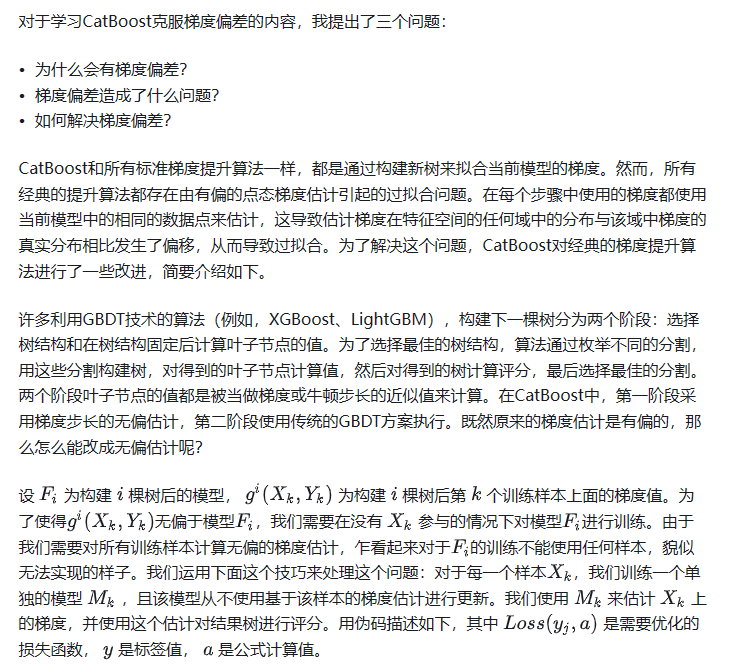

**预测偏移和排序提升**

1、预测偏移

对于学习预测偏移的内容，我提出了两个问题：

什么是预测偏移？
用什么办法解决预测偏移问题？
预测偏移（Prediction shift）是由梯度偏差造成的。在GDBT的每一步迭代中, 损失函数使用相同的数据集求得当前模型的梯度, 然后训练得到基学习器, 但这会导致梯度估计偏差, 进而导致模型产生过拟合的问题。 CatBoost通过采用排序提升 (Ordered boosting) 的方式替换传统算法中梯度估计方法，进而减轻梯度估计的偏差，提高模型的泛化能力。下面我们对预测偏移进行详细的描述和分析。

首先来看下GBDT的整体迭代过程：

GBDT算法是通过一组分类器的串行迭代，最终得到一个强学习器，以此来进行更高精度的分类。它使用了前向分布算法，弱学习器使用分类回归树(CART)。
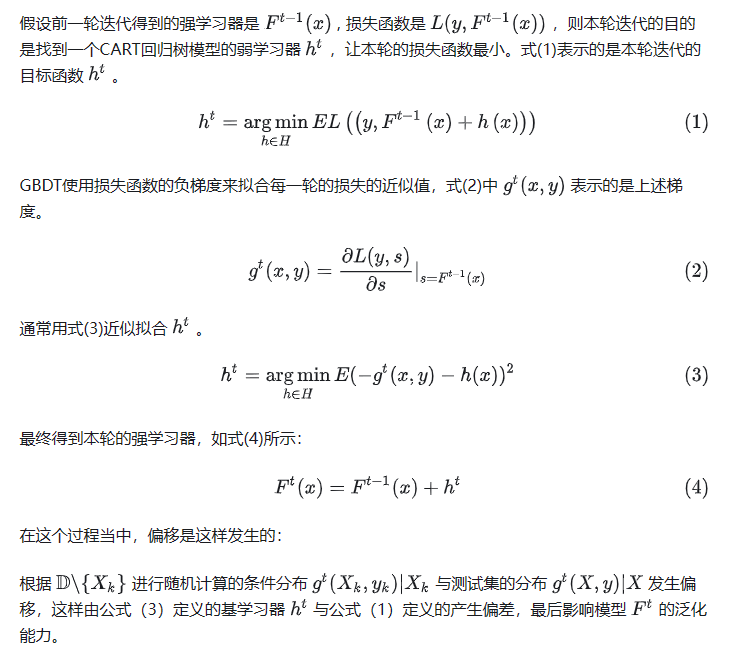

2、排序提升

为了克服预测偏移问题，CatBoost提出了一种新的叫做Ordered boosting的算法。

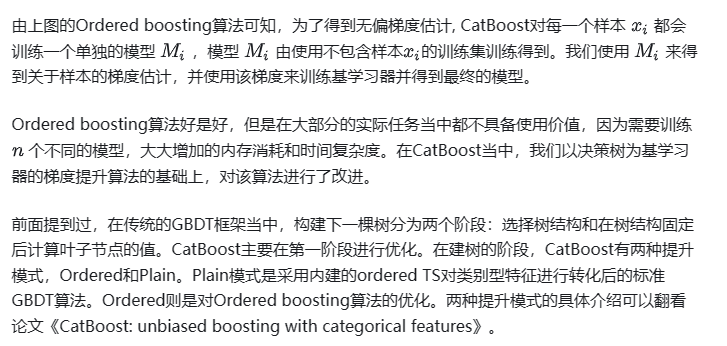

3、共用模型结构

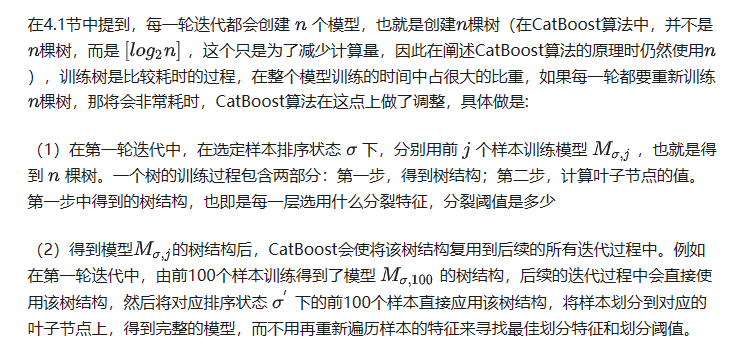

**快速评分**

CatBoost使用对称树（oblivious trees）作为基预测器。在这类树中，相同的分割准则在树的整个一层上使用。这种树是平衡的，不太容易过拟合。梯度提升对称树被成功地用于各种学习任务中。在对称树中，每个叶子节点的索引可以被编码为长度等于树深度的二进制向量。这在CatBoost模型评估器中得到了广泛的应用：我们首先将所有浮点特征、统计信息和独热编码特征进行二值化，然后使用二进制特征来计算模型预测值。

优点

- 性能卓越：在性能方面可以匹敌任何先进的机器学习算法；
- 鲁棒性/强健性：它减少了对很多超参数调优的需求，并降低了过度拟合的机会，这也使得模型变得更加具有通用性；
- 易于使用：提供与scikit集成的Python接口，以及R和命令行界面；
- 实用：可以处理类别型、数值型特征；
- 可扩展：支持自定义损失函数；

缺点

- 对于类别型特征的处理需要大量的内存和时间；
- 不同随机数的设定对于模型预测结果有一定的影响

# 数据准备

In [1]:
import pandas as pd
import numpy as np
import sklearn
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

In [2]:
#读取数据
data = pd.read_csv("../data/iris.csv")
print(data.head())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [3]:
#准备数据
data = data.dropna()
y = data['Species']
x = data.drop(['Species'],axis=1).astype('float64')

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 42)

# 模型训练

In [4]:
# 分类模型、参数
model = CatBoostClassifier(task_type='GPU')
param_grid = {'n_estimators': [10, 100, 200], 'max_depth': [5, 10, 15]}

# GridSearchCV优化参数、训练模型
gsearch = GridSearchCV(model, param_grid)
model = gsearch.fit(x_train, y_train)

Learning rate set to 0.5
0:	learn: 0.6149315	total: 22.4ms	remaining: 202ms
1:	learn: 0.4295585	total: 30.2ms	remaining: 121ms
2:	learn: 0.3138256	total: 36ms	remaining: 84ms
3:	learn: 0.2400044	total: 43ms	remaining: 64.5ms
4:	learn: 0.1903653	total: 49.5ms	remaining: 49.5ms
5:	learn: 0.1567704	total: 55.5ms	remaining: 37ms
6:	learn: 0.1328109	total: 62ms	remaining: 26.6ms
7:	learn: 0.1165786	total: 68.1ms	remaining: 17ms
8:	learn: 0.1043771	total: 76.1ms	remaining: 8.45ms
9:	learn: 0.0948435	total: 82.7ms	remaining: 0us
Learning rate set to 0.5
0:	learn: 0.6183685	total: 7.29ms	remaining: 65.7ms
1:	learn: 0.4199258	total: 14.2ms	remaining: 56.7ms
2:	learn: 0.3169970	total: 22ms	remaining: 51.3ms
3:	learn: 0.2452093	total: 29.4ms	remaining: 44.1ms
4:	learn: 0.1970652	total: 35.1ms	remaining: 35.1ms
5:	learn: 0.1703767	total: 40.6ms	remaining: 27.1ms
6:	learn: 0.1475726	total: 46.3ms	remaining: 19.8ms
7:	learn: 0.1279602	total: 51.8ms	remaining: 12.9ms
8:	learn: 0.1115348	total: 57.5ms

In [6]:
# 打印最优结果
print('DecisionTree params:', model.best_params_)

DecisionTree params: {'max_depth': 10, 'n_estimators': 10}


In [7]:
cat = CatBoostClassifier(max_depth=10, n_estimators=10, random_state = 0)
cat.fit(x_train, y_train)
cat.feature_importances_ # 特征重要性

Learning rate set to 0.5
0:	learn: 0.6959268	total: 8ms	remaining: 72ms
1:	learn: 0.5094939	total: 14.4ms	remaining: 57.8ms
2:	learn: 0.3600889	total: 17.8ms	remaining: 41.6ms
3:	learn: 0.2644527	total: 19.7ms	remaining: 29.5ms
4:	learn: 0.2275758	total: 25.5ms	remaining: 25.5ms
5:	learn: 0.1971487	total: 33ms	remaining: 22ms
6:	learn: 0.1717477	total: 40.8ms	remaining: 17.5ms
7:	learn: 0.1472590	total: 43.6ms	remaining: 10.9ms
8:	learn: 0.1261479	total: 45.7ms	remaining: 5.08ms
9:	learn: 0.1143489	total: 47.7ms	remaining: 0us


array([ 7.79488781,  8.8561831 , 27.16045363, 56.18847546])

Text(0, 0.5, 'Feature')

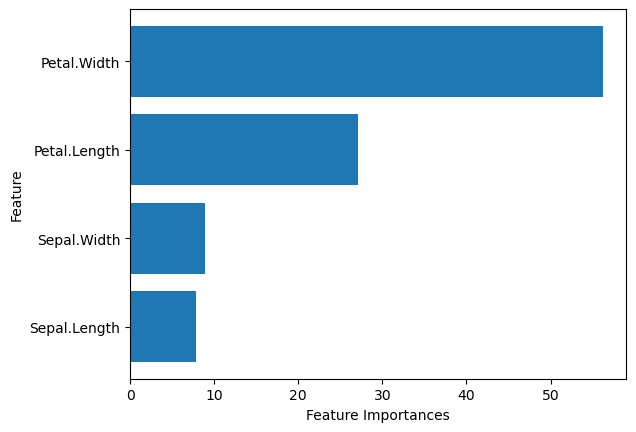

In [8]:
can = {n:v for n,v in zip(data.columns,cat.feature_importances_)}
plt.barh(list(can.keys()),list(can.values()),align = 'center')
plt.xlabel("Feature Importances")
plt.ylabel("Feature")

# 模型保存

In [9]:
# 法一
import joblib

# 保存模型
joblib.dump(model, '../test/best_models/cat.pkl')

# 加载模型
model = joblib.load('../test/best_models/cat.pkl')

In [10]:
# 法二
import pickle

with open('../test/best_models/cat.pkl', 'wb') as f:
    pickle.dump(model, f)
 
#读取Model
with open('../test/best_models/cat.pkl', 'rb') as f:
    model = pickle.load(f)

# 模型预测

In [11]:
prediction = model.predict(x_test)

In [12]:
# 计算准确率
acc = accuracy_score(y_test, prediction)
print("acc为：", acc)

acc为： 1.0


In [13]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       1.00      1.00      1.00        11
   virginica       1.00      1.00      1.00        12

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38

